In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import torch
import torch.nn as nn
import torch.nn.functional as F

DATA_PATH = "/mnt/d/Uni/Bachelorarbeit/linux/data/"

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

from src.log_mock import PrintLog
log = PrintLog()

import wandb
wandb.init(mode="disabled")

import experiments.base.multiclass_classification as exp

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [2]:
wapi = wandb.Api()
runs = wapi.runs("bayes/camelyon17")

In [13]:
import plotly.express as px
import pandas as pd
import dateutil
import datetime
import json

def create_plot_data_for_run(run):
    model_name = run.name.split("-")[0]
    if "bn-static" in run.tags:
        model_name += " (static bn)"

    results = run.summary["test_results"]

    return {
        "model": model_name,
        "accuracy": results["accuracy"],
        "ece": results["ece"],
        "sece": results["sece"],
        "log likelihood": results["log_likelihood"]
    }

def plot(data, value):
    plot = px.box(data, x="model", y=value, color="model")
    return plot

def pareto_plot(data):
    plot = px.scatter(data, x=f"accuracy", error_x=f"accuracy_std", y=f"sece", error_y=f"sece_std", color="model")
    return plot

def build_data(runs):
    rows = []
    for run in runs:
        if dateutil.parser.parse(run.created_at) < datetime.datetime(2023, 3, 10, 10, 0):
            continue
        if run.state != "finished":
            continue
        if "old" in run.tags:
            continue
        # if not "bn-static" in run.tags:
        #     continue
        if "swag" in run.name or "ivon" in run.name:
            continue
        rows.append(create_plot_data_for_run(run))
    return pd.DataFrame.from_dict(rows)

def aggregate_data(data):
    aggregated_data = data.groupby(["model"]).agg({
        "model": "first",
        "accuracy": ["mean", "sem"], 
        "sece": ["mean", "sem"],
        "ece": ["mean", "sem"], 
        "log likelihood": ["mean", "sem"]
    })
    aggregated_data.columns = [a[0] + "_std" if a[1] == "sem" else a[0] for a in aggregated_data.columns.to_flat_index()]
    aggregated_data["accuracy_std"] *= 2.0
    aggregated_data["sece_std"] *= 2.0
    aggregated_data["ece_std"] *= 2.0
    aggregated_data["log likelihood_std"] *= 2.0
    return aggregated_data

In [14]:
data = aggregate_data(build_data(runs))


In [16]:
data

,model,accuracy,accuracy_std,sece,sece_std,ece,ece_std,log likelihood,log likelihood_std
model,,,,,,,,,
bbb,bbb,0.647771,0.116195,-0.191454,0.095488,0.191454,0.095488,-0.920021,0.292906
bbb (static bn),bbb (static bn),0.882211,0.008239,-0.053401,0.004032,0.053401,0.004032,-0.370274,0.021842
map,map,0.716446,0.084545,-0.170425,0.082888,0.170425,0.082888,-0.778738,0.299164
map (static bn),map (static bn),0.898100,0.011371,-0.041259,0.007412,0.041259,0.007412,-0.271398,0.025764
mcd,mcd,0.535775,0.068229,-0.352887,0.074514,0.353839,0.075575,-1.224998,0.315817
mcd (static bn),mcd (static bn),0.880525,0.038901,-0.048554,0.027276,0.048554,0.027276,-0.305738,0.084126


In [15]:
pareto_plot(data)

In [17]:
data.to_csv(sep=",", header=True)

'model,model,accuracy,accuracy_std,sece,sece_std,ece,ece_std,log likelihood,log likelihood_std\nbbb,bbb,0.6477708294987679,0.11619548774672096,-0.1914536475463901,0.09548827986660918,0.1914536475463901,0.09548827986660918,-0.9200212806463242,0.2929063013263442\nbbb (static bn),bbb (static bn),0.8822112917900086,0.008238810462651921,-0.05340051291245522,0.004032207628767647,0.05340051291245522,0.004032207628767647,-0.3702742099761963,0.02184178707226432\nmap,map,0.7164460182189941,0.08454457952379268,-0.1704253447360098,0.0828880979714297,0.1704253447360098,0.0828880979714297,-0.7787383675575257,0.2991642775475501\nmap (static bn),map (static bn),0.8981000304222106,0.011371484588535367,-0.04125916456176607,0.0074122148518345875,0.04125916456176607,0.0074122148518345875,-0.27139833867549895,0.025764400508158872\nmcd,mcd,0.5357749164104462,0.06822935492386381,-0.35288667537975044,0.07451372095386893,0.3538387210388676,0.07557506295087237,-1.2249982476234436,0.31581661498507224\nmcd (stati

In [15]:
for run in runs:
    if dateutil.parser.parse(run.created_at) < datetime.datetime(2023, 3, 10, 10, 0):
        continue
    if run.state != "finished":
        continue
    if "test_results" not in run.summary:
        continue
    print(run.name, run.summary["test_results"])

swag-1-(3) {'ece': 'NaN', 'sece': 'NaN', 'wilds': [{'acc_slide:39': 0, 'count_slide:4': 0, 'count_slide:30': 0, 'acc_slide:3': 0, 'acc_slide:11': 0, 'acc_slide:12': 0, 'acc_slide:18': 0, 'acc_slide:35': 0, 'count_slide:34': 0, 'count_slide:24': 7727, 'count_slide:27': 4556, 'count_slide:40': 0, 'count_slide:44': 0, 'acc_slide:6': 0, 'count_slide:8': 0, 'count_slide:11': 0, 'count_slide:21': 3694, 'acc_wg': 0, 'acc_slide:24': 0, 'count_slide:25': 4334, 'count_slide:35': 0, 'acc_slide:19': 0, 'acc_slide:31': 0, 'acc_slide:44': 0, 'count_slide:1': 0, 'count_slide:29': 12742, 'count_slide:41': 0, 'count_slide:49': 0, 'acc_avg': 0, 'acc_slide:13': 0, 'acc_slide:47': 0, 'count_slide:2': 0, 'count_slide:9': 0, 'count_slide:14': 0, 'count_slide:36': 0, 'count_slide:38': 0, 'acc_slide:10': 0, 'acc_slide:26': 0, 'acc_slide:34': 0, 'acc_slide:42': 0, 'count_slide:12': 0, 'acc_slide:48': 0, 'acc_slide:29': 0, 'count_slide:13': 0, 'count_slide:17': 0, 'count_slide:33': 0, 'count_slide:37': 0, 'acc_

In [8]:
import yaml
from pathlib import Path

list(yaml.safe_load_all(Path("camelyon_tune.yaml").read_text()))

[{'name': 'SLURM',
  'partition': 'gpu_4',
  'job-name': 'camelyon',
  'num_parallel_jobs': 120,
  'ntasks': 1,
  'cpus-per-task': 16,
  'mem-per-cpu': 8000,
  'time': 400,
  'sbatch_args': {'gres': 'gpu:1',
   'container-image': './../../../bdl_container.sqsh',
   'container-mounts': './../..:/work,/etc/slurm/task_prolog:/etc/slurm/task_prolog',
   'container-workdir': '/work/experiments/camelyon',
   'container-writable': ''}},
 {'name': 'DEFAULT',
  'path': 'results',
  'repetitions': 1,
  'reps_per_job': 1,
  'reps_in_parallel': 1,
  'params': {'batch_size': 32,
   'data_path': '/mnt/d/Uni/Bachelorarbeit/linux/data',
   'epochs': 2,
   'use_amp': True,
   'eval_samples': 10,
   'ece_bins': 10,
   'train_on_val': True,
   'disable_wandb': True,
   'eval_while_train': True,
   'subsample': 0,
   'test_subsample': 0}},
 {'name': 'BBB',
  'params': {'model': 'bbb',
   'members': 1,
   'prior_std': 1.0,
   'optimizer': {'base': {'lr': 0.001, 'momentum': 0.9, 'weight_decay': 0.01},
    '

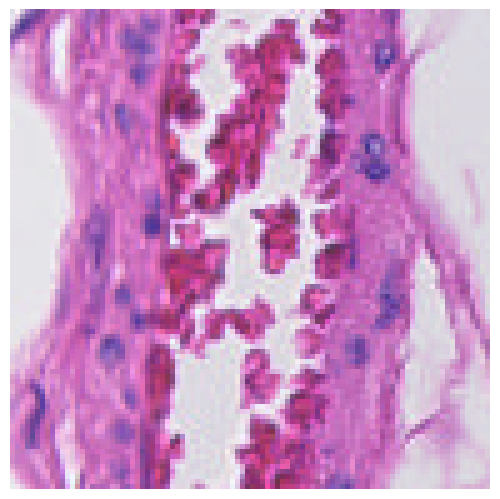

In [24]:
from experiments.base import wilds1
testloader = wilds1.camelyon_loader(wilds1.camelyon_split(DATA_PATH, "test"), 1)

wilds1.imshow(next(iter(testloader))[0][0])

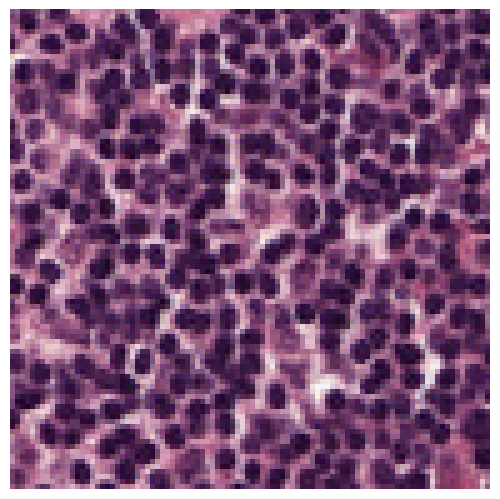

In [23]:
trainloader = wilds1.camelyon_loader(wilds1.camelyon_split(DATA_PATH, "train"), 1)

wilds1.imshow(next(iter(trainloader))[0][0])

In [8]:
from experiments.camelyon.models import get_model
from experiments.camelyon.camelyon import train_model, eval_model

config = {
    "model": "bbb",
    "batch_size": 32,
    "data_path": DATA_PATH,
    "epochs": 1,
    "use_amp": True,
    "eval_samples": 10,
    "ece_bins": 10,
    "train_on_val": True,
    "disable_wandb": True,

    "members": 1,
    "prior_std": 1.0,
    "optimizer": {
        "base": {
            "lr": 0.001,
            "momentum": 0.9,
            "weight_decay": 0.0
        },
        "bbb": {
            "dataset_size": 33568,
            "mc_samples": 2,
            "kl_rescaling": 1.0
        }
    }
}

In [ ]:
model = get_model("bbb", config, device)

train_model(model, device, config, log, "results/")

In [23]:
from experiments.camelyon.models import get_model

config = {
    "batch_size": 32,
    "data_path": DATA_PATH,
    "disable_wandb": True,
    "use_amp": True,
    "eval_samples": 10,
    "ece_bins": 10,

    "members": 1,
    "optimizer": {
        "base": {
            "lr": 0.001,
            "momentum": 0.9,
            "weight_decay": 0.01
        },
        "swag": {
            "update_interval": 630,
            "start_epoch": 3,
            "deviation_samples": 30
        }
    }
}

swag_model = get_model("swag", config, device)
swag_model.load_state_dict(torch.load("/mnt/d/Uni/PdF/results/camelyon/SWAG/rep_00swag_final.tar"))

In [3]:
map_model = get_model("map", config, device)
map_model.load_state_dict(torch.load("/mnt/d/Uni/PdF/results/camelyon/MAP/rep_00map_final.tar"))

In [ ]:
from src.algos.util import patch_batchnorm

patch_batchnorm(swag_model.models[0], track_running_stats=False)
swag_model.models[0]

In [ ]:
def check_norm(module):
    if "BatchNorm" in module.__class__.__name__:
        print(module.running_mean.min())

swag_model.models[0].apply(check_norm)

In [26]:
from experiments.camelyon.camelyon import eval_model

eval_model(swag_model, config, device, subsample=100)

tensor(-0.7290)


{'wilds': ({'acc_avg': 0.6087499856948853,
   'acc_slide:0': 0.0,
   'count_slide:0': 0.0,
   'acc_slide:1': 0.0,
   'count_slide:1': 0.0,
   'acc_slide:2': 0.0,
   'count_slide:2': 0.0,
   'acc_slide:3': 0.0,
   'count_slide:3': 0.0,
   'acc_slide:4': 0.0,
   'count_slide:4': 0.0,
   'acc_slide:5': 0.0,
   'count_slide:5': 0.0,
   'acc_slide:6': 0.0,
   'count_slide:6': 0.0,
   'acc_slide:7': 0.0,
   'count_slide:7': 0.0,
   'acc_slide:8': 0.0,
   'count_slide:8': 0.0,
   'acc_slide:9': 0.0,
   'count_slide:9': 0.0,
   'acc_slide:10': 0.0,
   'count_slide:10': 0.0,
   'acc_slide:11': 0.0,
   'count_slide:11': 0.0,
   'acc_slide:12': 0.0,
   'count_slide:12': 0.0,
   'acc_slide:13': 0.0,
   'count_slide:13': 0.0,
   'acc_slide:14': 0.0,
   'count_slide:14': 0.0,
   'acc_slide:15': 0.0,
   'count_slide:15': 0.0,
   'acc_slide:16': 0.0,
   'count_slide:16': 0.0,
   'acc_slide:17': 0.0,
   'count_slide:17': 0.0,
   'acc_slide:18': 0.0,
   'count_slide:18': 0.0,
   'acc_slide:19': 0.0,
   

In [10]:
swag_model.optimizers[0].state["__deviations"]

tensor([[ 2.2165e-02,  1.3912e-02,  4.7901e-03,  ...,  6.6772e-03,
          1.0793e-02,  2.2088e-03],
        [-4.0652e-02, -2.8253e-02, -2.3070e-02,  ..., -1.9375e-03,
          4.5299e-03, -2.4099e-03],
        [-4.1332e-02, -2.9972e-02, -2.1521e-02,  ..., -3.7937e-03,
          1.8733e-03, -4.1334e-03],
        ...,
        [-2.5996e-02, -1.7828e-02, -1.3659e-02,  ..., -5.0741e-03,
         -5.6074e-03, -5.3395e-03],
        [-1.9012e-03, -1.4884e-03, -5.1615e-03,  ..., -8.0732e-03,
         -1.1713e-03, -3.3557e-03],
        [-9.9659e-03, -6.4794e-03, -8.7379e-04,  ...,  6.8125e-03,
         -6.2278e-05,  2.1478e-03]], device='cuda:0')